In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from numbers import Real

from tdse.propagator.box1d import Propagator_on_1D_Box
from tdse.evol import get_D1_tridiag, get_M1_tridiag
from tdse.tridiag import tridiag_forward, tridiag_backward

class Propagator_on_1D_Box_with_field(Propagator_on_1D_Box):
    def __init__(self, N, dx, Vx, At, q=-1.0, x0=0.0, hbar=1.0, mass=1.0):
        """
        Initalize
        
        Parameters
        ----------
        At : callable of a single real number t (time)
            vector potential as a function of time
        q : float
            charge of a particle described by the wavefunction
        """
        
        if not callable(At):
            _msg = "`At` should be a callable. Given: {}"
            raise ValueError(_msg.format(At))
        self.A = At
        
        if not isinstance(float(q), Real):
            _msg = "`q` should be real number. Given: {}"
            raise ValueError(_msg.format(q))
        self.q = float(q)
        
        # Process arguments that is common with parent propagator
        # and construct matrices that is common with field-absent case
        super().__init__(N, dx, Vx, x0=x0, hbar=hbar, mass=mass)
        
        # Construct matrices for field-present case
        self.M1 = get_M1_tridiag(self.N)
        _D1 = get_D1_tridiag(self.N, self.dx)
        self.M1HA_over_ihbar_At = (self.q / self.mass) * _D1
#         self.M1HA_const_coef = 1.j * (self.q * self.hbar / self.mass)
#         self.M1HA_over_A = _M1HA_const_coef * _D1
        
        
        
    def propagate_with_field(self, wf, dt, t_start, Nt=1):
        """Propagate the wavefunction in the presence of the field
        
        Notes
        -----
        When the field strength is zero,
        consider using `propagate()` method for calculation performance
        
        Returns
        -------
        t_final : float
            time after the propagation ends
        """
        if not isinstance(wf, np.ndarray) or wf.dtype != np.complex:
            raise ValueError("The wavefunction should be a complex type numpy array")
        _wf = wf
        
        if not isinstance(float(t_start), Real):
            raise ValueError("`t_start` should be a real number. Given: {}".format(t_start))
        _t_start = float(t_start)
        
        if not isinstance(float(dt), Real):
            raise ValueError("`dt` should be a real number. Given: {}".format(dt))
        _dt = float(dt)
        
        if not isinstance(Nt, Integral) or Nt <= 0:
            raise ValueError("`Nt` should be a positive integer. Given: {}".format(Nt))
        _Nt = Nt
        
        _quarter_dt_M2H0_over_ihbar = (-0.25j * dt / self.hbar) * self.M2H
        _M2U0_forward_quarter = self.M2 + _quarter_dt_M2H0_over_ihbar
        _M2U0_backward_quarter = self.M2 - _quarter_dt_M2H0_over_ihbar
        
        _wf_mid = np.empty_like(_wf, dtype=_wf.dtype)
        _t = _t_start
        for _it in range(_Nt):
            
            tridiag_forward(_M2U0_forward_quarter, _wf, _wf_mid)
            tridiag_backward(_M2U0_backward_quarter, _wf, _wf_mid)
            
            _half_dt_M1HA_over_ihbar = (0.5*dt * self.A(_t+0.5*_dt)) * self.M1HA_over_ihbar_At
            _M1UA_forward_half = self.M1 + _half_dt_M1HA_over_ihbar
            _M1UA_backward_half = self.M1 - _half_dt_M1HA_over_ihbar
            tridiag_forward(_M1UA_forward_half, _wf, _wf_mid)
            tridiag_backward(_M1UA_backward_half, _wf, _wf_mid)
            
            tridiag_forward(_M2U0_forward_quarter, _wf, _wf_mid)
            tridiag_backward(_M2U0_backward_quarter, _wf, _wf_mid)
            
            _t += _dt
            
        return _t

In [3]:
def A_func(t):
    return 0.0

prop = Propagator_on_1D_Box_with_field(N=101, dx=0.2, Vx=0.0, At=A_func)

In [4]:
wf = prop.propagate_to_ground_state()

iteration count at end: 428


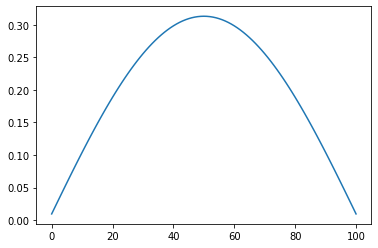

In [5]:
fig, ax = plt.subplots()
ax.plot(np.arange(prop.wf.N), wf.real)